In [1]:
import numpy as np
import pynbody
import matplotlib.pyplot as plt
import sys, os, glob, pickle, struct
import plot_tools
import make_plots
from scipy import stats
import add_obs

In [2]:
def bin_stats(x, values):
    bin_means, bin_edges, binnumber = stats.binned_statistic(x, values, statistic='mean', bins=25)
    bin_std, bin_edges, binnumber = stats.binned_statistic(x, values, statistic='std', bins=25)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return bin_centers, bin_means, bin_std

def do_filter(a, b, lower_limit=1):
    """Filter two lists such that if one entry is invalid, both elements from the lists are removed."""
    
    def is_valid(elm):
        if elm is None:
            return False
        return elm > lower_limit and np.isfinite(elm)

    #print(len(b))
    for idx in range(len(b) - 1, -1, -1):
        #print(idx)
        if not is_valid(b[idx]) or not is_valid(a[idx]) :
            a = np.delete(a,idx)
            b = np.delete(b,idx)
    return a,b

In [3]:
# Filenames
pickles = glob.glob("/scratch/hc2347/pickles/60/Final*")
print(pickles)
pickles = sorted(pickles)[:6]

# Load the entries
entry = {}
for pickl in pickles:
    entry[pickl.split('_')[1][:3]] = plot_tools.load_halos_pickle(pickl)

['/scratch/hc2347/pickles/60/Final60_0.20482851813348169.p', '/scratch/hc2347/pickles/60/Final60_0.9460410532092647.p', '/scratch/hc2347/pickles/60/Final60_2.994260669667267.p', '/scratch/hc2347/pickles/60/Final60_3.9899526108321393.p', '/scratch/hc2347/pickles/60/Final60_4.973230807516999.p', '/scratch/hc2347/pickles/60/Final60_5.965686827751768.p', '/scratch/hc2347/pickles/60/Final60_9.894320197673142.p', '/scratch/hc2347/pickles/60/Final60_2.1407388896027233.p']


0.2
0 0
0.9


/home/hc2347/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10


0 1
2.1
0 2
2.9
1 0
3.9
1 1
4.9
1 2


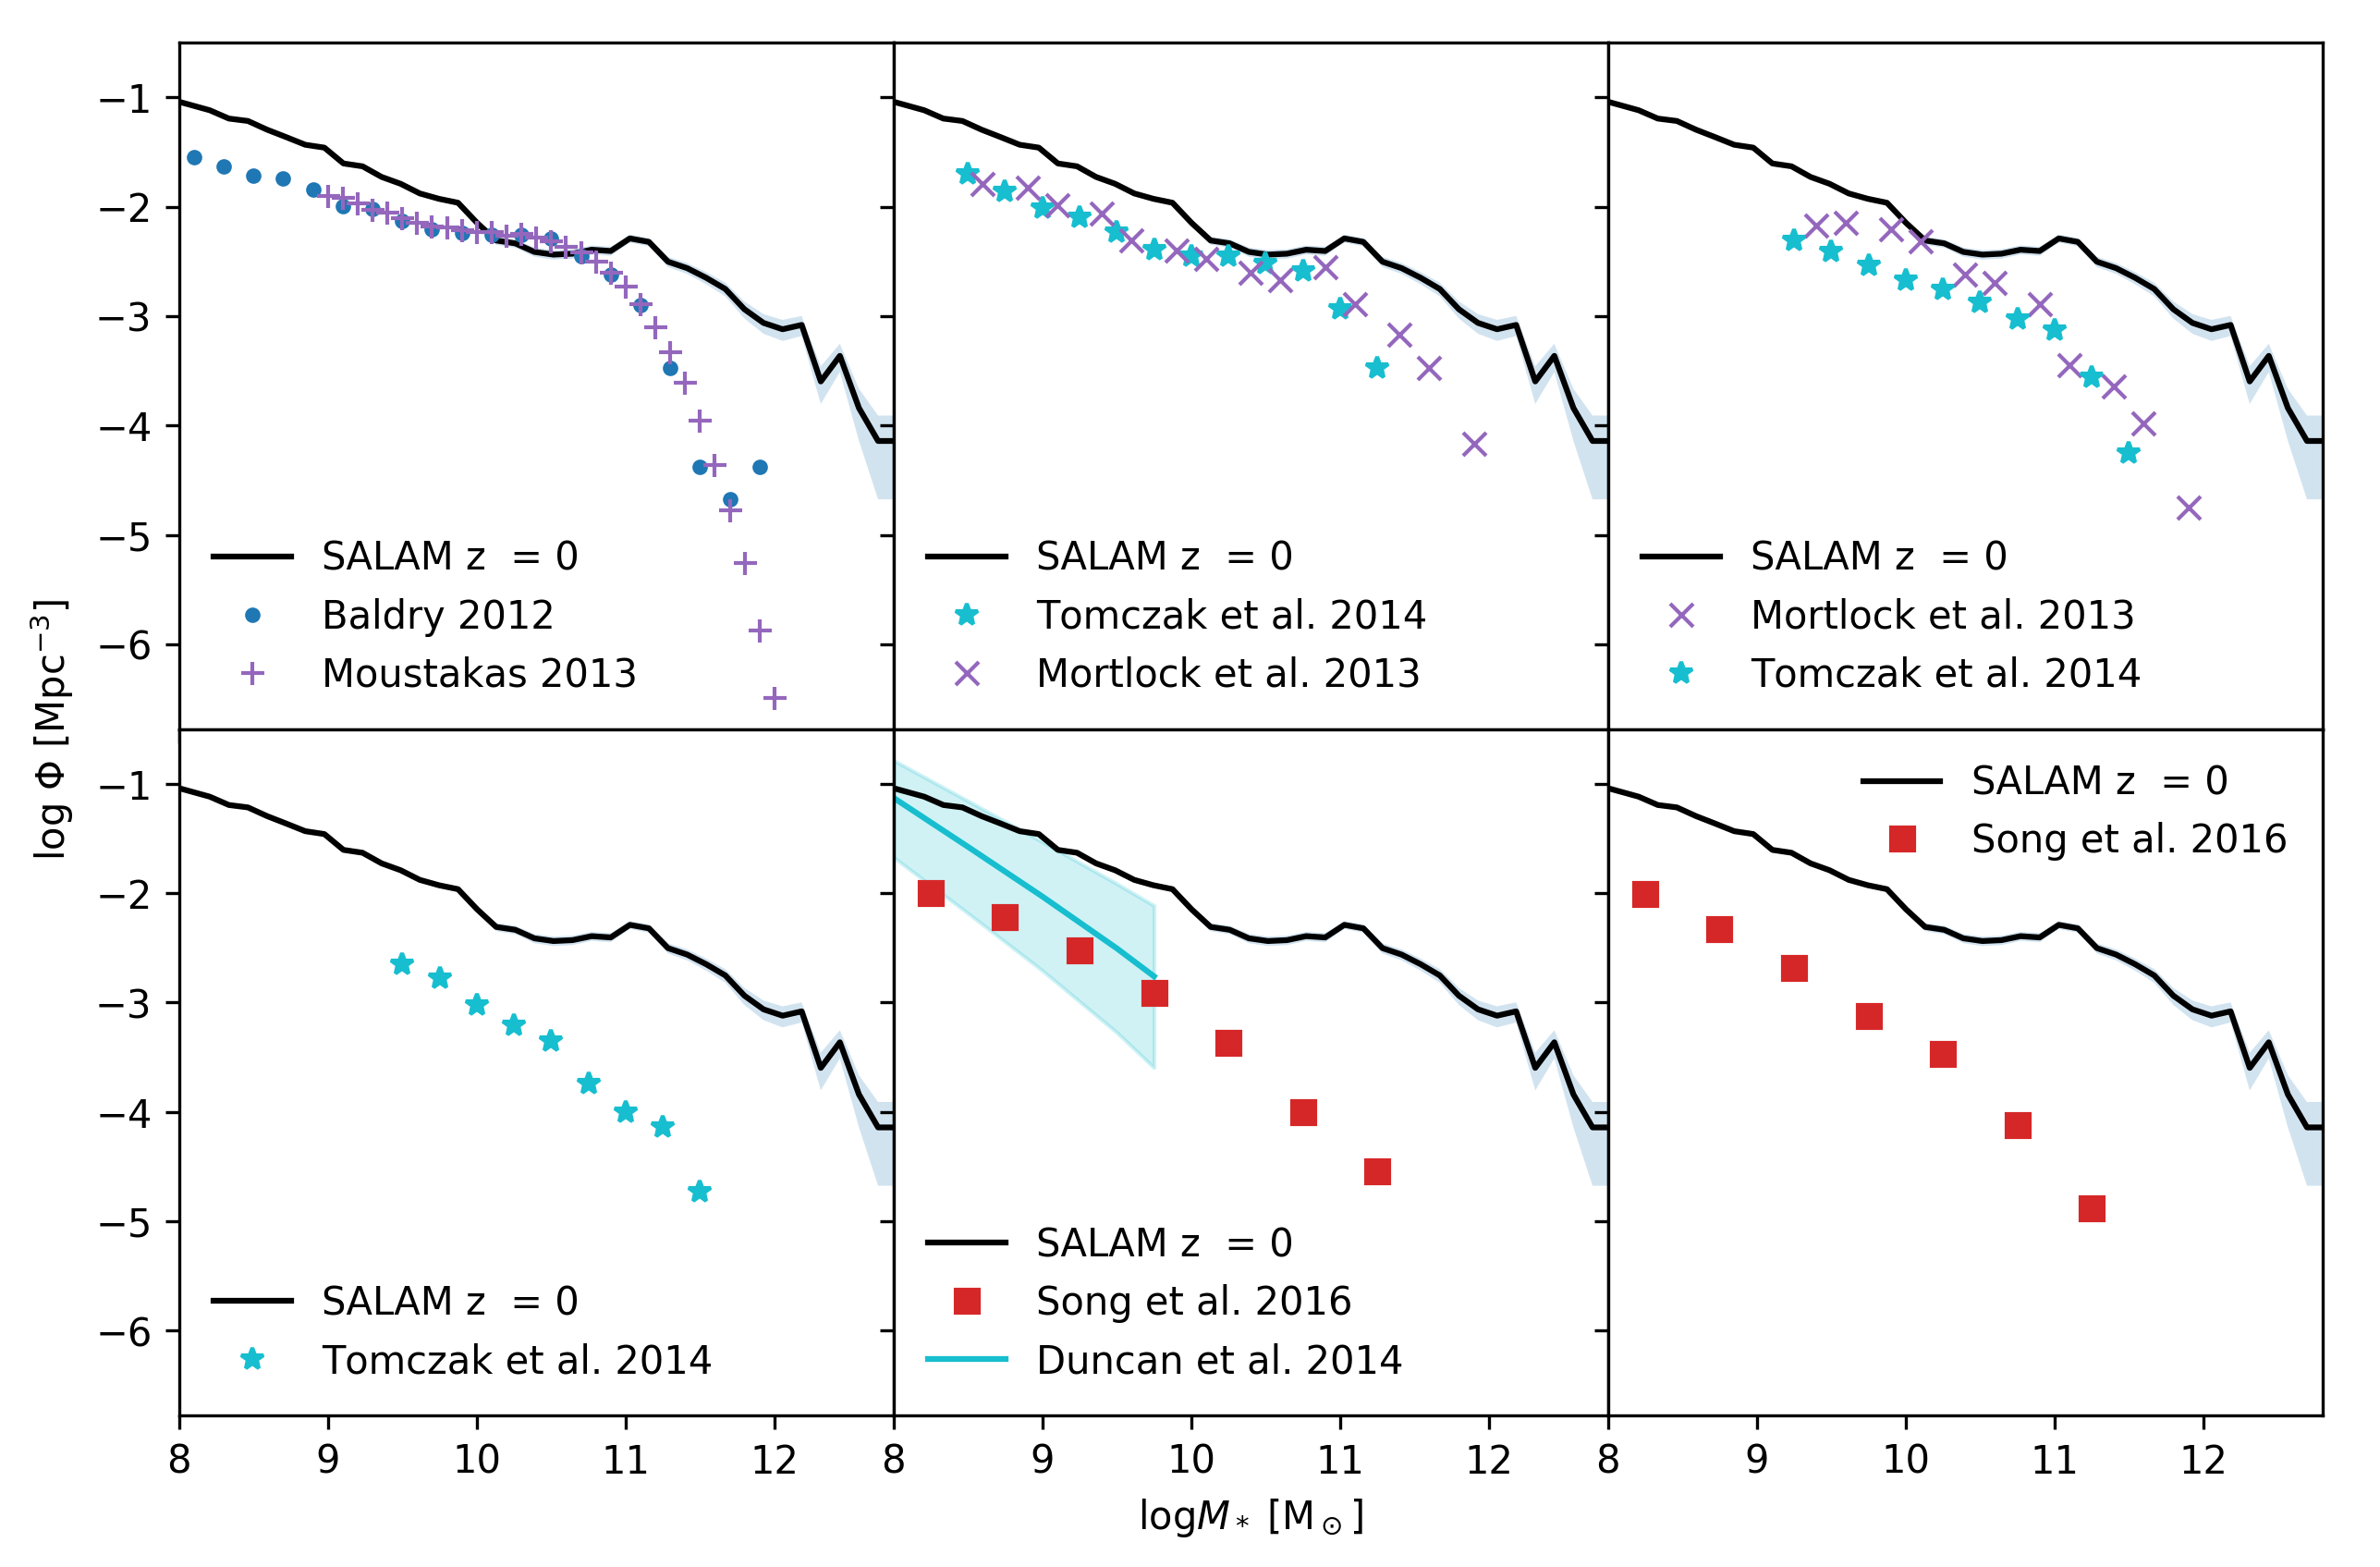

In [11]:
# SMF plot

def plot_smf(mstar, size):
    mstar = plot_tools.filter_list(mstar, 1, 1e20)
    logM = np.log10(mstar)
    nbins = 50
    V = size**3
    Phi, edg = np.histogram(logM, bins=nbins)    #Unnormalized histogram and bin edges
    dM = edg[1] - edg[0]
    Max = np.array(edg[0:-1]) + dM/2
    yerr = np.sqrt(Phi)/V/dM
    
    Phi = Phi/V/dM
    return Max, Phi, yerr

xlabel = r'log$M_*$ [M$_\odot$]'
ylabel = r'log $\Phi$ [Mpc$^{-3}$]'

fig, axs = plt.subplots(2, 3, figsize = (9, 6), dpi = 300, sharex = True, sharey = True, gridspec_kw = {'wspace':0, 'hspace':0})
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

for idx, k in enumerate(sorted(entry.keys())):
    print(k)
    x, y, yerr= plot_smf(entry['0.2']['mstar'], 60)
    
    row = int(idx/3)
    col = idx%3
    ax = axs[row][col]
    print(row, col)
    ax.plot(x, np.log10(y), color = "black", label = 'SALAM z  = ' + str(int(round(float(0),0))))
    ax.fill_between(x, np.log10(y + yerr), np.log10(y - yerr), alpha = 0.2)
    ax.set_xlim(8, 12.8)
    ax.label_outer()

# Adding observations for z = 0
ax = axs[0][0]
baldry = np.genfromtxt('obs/Baldry_2012_SMF_z0.csv',unpack=True,skip_header=1,delimiter=',')
moustakas = np.genfromtxt('obs/Moustakas_2013_SMF_z0.csv', unpack=True, skip_header=1, delimiter=',')
ax.plot(baldry[0], np.log10(baldry[1]*10e-4), marker = '.', label='Baldry 2012', linestyle='None', color = 'tab:blue')
ax.plot(moustakas[0], moustakas[1], marker = '+', label='Moustakas 2013', linestyle='None', color = 'tab:purple')
ax.errorbar(baldry[0], np.log10(baldry[1]), fmt='none')
ax.legend(frameon=False)

# z = 1
ax = axs[0][1]
tomczak1 = np.genfromtxt('obs/Tomczak_2014_SMF_z1.csv', unpack=True, skip_header=1, delimiter=',')
ax.plot(tomczak1[0], tomczak1[1], linestyle = "None", marker = '*', label = "Tomczak et al. 2014", color = 'tab:cyan')
mortlock = np.genfromtxt('obs/Mortlock_2013_SMF_z1.csv', unpack=True, skip_header=1, delimiter=',')
ax.plot(mortlock[0], mortlock[1], linestyle = 'None', marker = 'x', label = "Mortlock et al. 2013", color = 'tab:purple')

# z = 2
ax = axs[0][2]
mortlock2 = np.genfromtxt('obs/Mortlock_2013_SMF_z2.csv', unpack=True, skip_header=1, delimiter=',')
ax.plot(mortlock2[0], mortlock2[1], label="Mortlock et al. 2013", marker = 'x', linestyle = "None", color = 'tab:purple')
tomczak2 = np.genfromtxt('obs/Tomczak_2014_SMF_z2.csv', unpack=True, skip_header=1, delimiter=',')
ax.plot(tomczak2[0], tomczak2[4], ls = 'None', marker = '*', label = "Tomczak et al. 2014", color = 'tab:cyan')

# z = 3
ax = axs[1][0]
tomczak2 = np.genfromtxt('obs/Tomczak_2014_SMF_z3.csv', unpack=True, skip_header=1, delimiter=',')
ax.plot(tomczak2[0], tomczak2[1], label="Tomczak et al. 2014", marker = '*', ls = 'None', color = 'tab:cyan')
muzzin3 = np.genfromtxt('obs/Muzzin_2013_SMFz2.5-3.csv', unpack=True, skip_header=1, delimiter = ',')
#ax.plot(muzzin3[1], muzzin3[2] + 1, label = "Muzzin+13", marker = ".")

# z = 4
ax = axs[1][1]
song = np.genfromtxt('obs/Song_2016_SMF_z4.csv', unpack=True, skip_header=1, delimiter=',')
ax.plot(song[0], song[1], label="Song et al. 2016", marker = 's', ls = 'None', color = 'tab:red')
mstar, y, yup, yl = add_obs.SMF_Duncan(ax, 4)
ax.plot(mstar, np.log10(y), label = "Duncan et al. 2014", color = 'tab:cyan')
ax.fill_between(mstar, np.log10(yup), np.log10(yl), color = 'tab:cyan', alpha = 0.2)
# z = 5
ax = axs[1][2]
song = np.genfromtxt('obs/Song_2016_SMF_z5.csv', unpack=True, skip_header=1, delimiter=',')
ax.plot(song[0], song[1], label = "Song et al. 2016", marker = 's', ls = 'None', color = 'tab:red')

for row in axs:
    for ax in row:
        ax.legend(frameon=False)
        
plt.tight_layout()
plt.savefig("/scratch/hc2347/reports/SALAMvNIHAO/SMF_big.png")

0.2
0.9
2.1
2.9
3.9
4.9


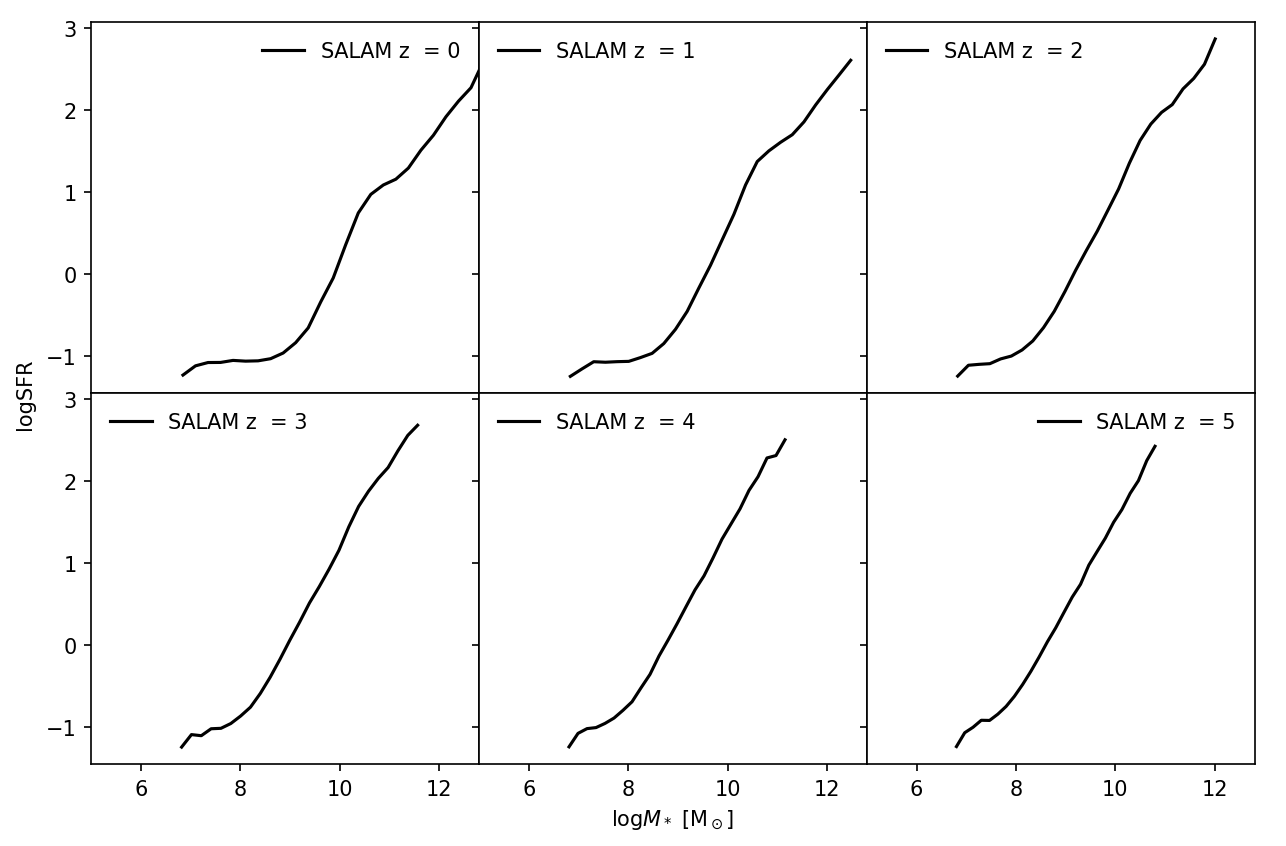

In [75]:
# SMR
def bin_stats(x, values):
    bin_means, bin_edges, binnumber = stats.binned_statistic(x, values, statistic='mean', bins=25)
    bin_std, bin_edges, binnumber = stats.binned_statistic(x, values, statistic='std', bins=25)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return bin_centers, bin_means, bin_std

def do_filter(a, b, lower_limit=1):
    """Filter two lists such that if one entry is invalid, both elements from the lists are removed."""
    
    def is_valid(elm):
        if elm is None:
            return False
        return elm > lower_limit and np.isfinite(elm)

    #print(len(b))
    for idx in range(len(b) - 1, -1, -1):
        #print(idx)
        if not is_valid(b[idx]) or not is_valid(a[idx]) :
            a = np.delete(a,idx)
            b = np.delete(b,idx)
    return a,b
xlabel = 'log$M_*$ [M$_\odot$]'
ylabel = 'logSFR'

fig, axs = plt.subplots(2, 3, figsize = (9, 6), dpi = 150, sharex = True, sharey = True, gridspec_kw = {'wspace':0, 'hspace':0})
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

for idx, k in enumerate(sorted(entry.keys())):
    print(k)
    x = np.log10(entry[k]['mstar'])
    y = np.log10(entry[k]['sfr_100'])
    x, y = do_filter(x,y,-10)    
    sfrc, sfrm, sfrs = bin_stats(x, y)
    row = int(idx/3)
    col = idx%3
    ax = axs[row][col]
    ax.plot(sfrc, sfrm, color = "black", label = 'SALAM z  = ' + str(int(round(float(k),0))))
    ax.set_xlim(5, 12.8)
    ax.label_outer()

for row in axs:
    for ax in row:
        ax.legend(frameon=False)
        
plt.tight_layout()